In [1]:
#Importing of all the necessary mods
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_recall_curve
# from sklearn.metrics import multilabel_confusion_matrix

Using TensorFlow backend.


In [2]:
# Reading the csv files
#fashion_df = pd.read_csv("./datasets/fashion_text_dataset.csv")
# Reading csv file of train set
fashion_df = pd.read_csv("./datasets/TIL_NLP_train_dataset.csv")
# Reading csv file of test set
fashion_test_df = pd.read_csv("./datasets/TIL_NLP_test_dataset.csv")

In [3]:
# Showing the first few columns of the train dataset
fashion_df.head(20)

,id,word_representation,outwear,top,trousers,women dresses,women skirts
0,0,w7718 w173355 w138132 w232277 w90685 w314686 w...,1,0,1,0,0
1,1,w195317 w127737 w171593 w22890 w342007 w217871...,1,0,1,0,0
2,2,w247655 w270233 w261113 w337250 w366000 w37873...,0,1,1,0,0
3,3,w279289 w395855 w61795 w286461 w308610 w27013 ...,1,0,1,0,0
4,4,w254516 w135431 w115724 w331534 w256214 w71240...,1,0,1,0,0
5,5,w53495 w306061 w372126 w47982 w66980 w189406 w...,1,0,0,0,1
6,6,w237465 w256553 w286461 w382662 w206066 w12125...,1,0,0,1,0
7,7,w173317 w39222 w207614 w136665 w394246 w197783...,1,1,1,0,0
8,8,w373517 w37419 w358253 w162965 w286461 w204762...,1,0,0,0,0
9,9,w230409 w109269 w369689 w186076 w377961 w21787...,1,1,0,0,0


In [4]:
# Showing the first few columns of the test dataset
fashion_test_df.head(10)

,id,word_representation
0,0,w373517 w383437 w374393 w87179 w289496 w327385...
1,1,w237465 w167111 w279437 w194870 w351537 w17560...
2,2,w151648 w93366 w121255 w193800 w71240 w48576 w...
3,3,w182664 w317736 w33852 w111248 w45374 w209361 ...
4,4,w206647 w236725 w99560 w338476 w75409 w36882 w...
5,5,w256553 w182887 w239430 w96414 w276473 w217871...
6,6,w305957 w254429 w215751 w155034 w287643 w45765...
7,7,w318673 w350483 w356690 w186076 w151648 w34893...
8,8,w500001 w128292 w253354 w254516 w102910 w37439...
9,9,w41024 w237465 w95569 w174897 w103096 w237465 ...


In [5]:
#This displays the relevant information of the dataframe
#Train Set
print("Information of Train Set\n")
fashion_df.info()
#Test Set
print("\nInformation of Test Set\n")
fashion_test_df.info()

Information of Train Set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   7380 non-null   int64 
 1   word_representation  7380 non-null   object
 2   outwear              7380 non-null   int64 
 3   top                  7380 non-null   int64 
 4   trousers             7380 non-null   int64 
 5   women dresses        7380 non-null   int64 
 6   women skirts         7380 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 403.7+ KB

Information of Test Set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   2460 non-null   int64 
 1   word_representation  2460 non-null   object
dtypes: int64(1), object(1)
memory usage: 38.6+

# GloVe Matrix Conversion
For word embedding (using CBOW)

In [6]:
# Load the dictionary back from the pickle file.
import pickle

words = pickle.load( open( "./datasets/word_embeddings.pkl", "rb" ) )

In [7]:
print("Printing out random mask: ",words["w365885"])

Printing out random mask:  [-0.2974     0.13021    0.44774   -0.51027   -0.15967    0.34781
 -0.0073979  0.19348   -0.37376   -0.16468    0.64726   -0.33593
 -0.34176    0.033171  -0.32817   -0.50221   -0.19317   -0.53613
 -0.87927   -0.39061    0.69842    0.2139    -0.68798    0.73236
  0.94687   -0.42926    0.3609    -0.43389    0.30961    0.48626
  0.43969    0.58117   -0.46265   -0.28028   -0.02724    0.25968
 -0.73342    0.11206   -0.31721    0.045954  -0.67666   -0.30504
 -0.53005   -0.030116  -0.10036   -0.18755    0.26206   -1.2814
  0.31223   -0.4429     0.37722   -0.18759    0.96948    1.2398
 -0.068121  -2.361     -0.086176   0.38622    1.6444     0.51647
 -0.55111    0.91737   -0.66038   -0.28121    0.37626   -0.35154
  0.66515   -0.17435    0.61422    0.21745   -0.67409    0.36388
  0.058988   0.052989   0.3081    -0.32066   -0.18457   -0.51273
 -1.0552    -0.25697    0.36672   -0.02435   -0.37087   -0.0038253
 -0.96345   -0.19426   -0.099656  -0.62601   -0.33331   -0.0708

In [8]:
print(words.keys()) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
# Importing Mods
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

In [10]:
# Extract word embeddings
embeddings_index = dict()
for line in words:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [11]:
vocabulary_size = len(words)
print(vocabulary_size)

400000


In [12]:
# Create Weighted Matrix (Incomplete)
#embedding_matrix = np.zeros((vocabulary_size, 100))
#for word, index in tokenizer.word_index.items():
#    if index > vocabulary_size - 1:
#        break
#    else:
#        embedding_vector = embeddings_index.get(word)
#        if embedding_vector is not None:
#            embedding_matrix[index] = embedding_vector

# Word2vec Conversion

In [13]:
# importing all necessary modules 
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 

import gensim
from gensim.models import Word2Vec 
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [14]:
# train model
keys = np.array(list(words.keys()))
model = Word2Vec(keys, min_count=1)

In [15]:
#Print out model
print(model)

Word2Vec(vocab=11, size=100, alpha=0.025)


In [16]:
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

['w', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [17]:
# access vector for one word
print(model['w'])

[ 1.42384470e-01 -5.42612970e-02  3.04510802e-01 -1.71501905e-01
 -2.46663973e-01 -5.31137645e-01 -5.63695014e-01 -3.91395442e-04
  2.37625446e-02 -5.72090782e-02  3.98752570e-01  1.39456525e-01
 -2.04495043e-01  2.80202925e-01  2.22028598e-01  5.52487224e-02
  9.76192132e-02  1.10968255e-01 -1.47381052e-01  9.80239511e-02
  1.81352481e-01  9.74731371e-02 -2.94957608e-01 -5.54291159e-02
 -3.61579269e-01 -1.70854464e-01 -2.61028912e-02  4.46648985e-01
  8.34959969e-02  4.78527725e-01 -4.20618922e-01 -1.58530623e-01
 -3.23513716e-01 -4.10511196e-01 -2.59529263e-01  3.52950454e-01
  1.44535094e-01 -1.47943854e-01 -1.64518982e-01  3.11634660e-01
  6.04795516e-01  7.26058856e-02  1.87233046e-01 -1.87156841e-01
  6.49046246e-03 -8.17626193e-02 -5.49643189e-02 -2.44306967e-01
 -2.06213847e-01 -3.46590042e-01 -2.88790196e-01  6.99248239e-02
 -5.18031955e-01 -5.42897463e-01  4.42513615e-01 -4.50396270e-01
 -1.33172870e-01  1.65596068e-01 -4.09031034e-01  2.30557412e-01
  5.79254292e-02 -5.95918

In [18]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

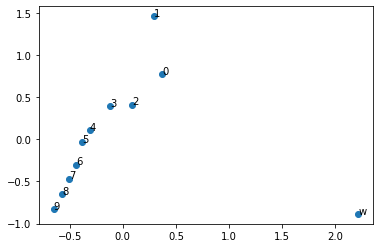

In [19]:
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

# -- End of word embedding --

In [ ]:
#This displays the value count of the various categories
#Total outwear counts
fashion_df.outwear.value_counts()

In [ ]:
#Total top counts
fashion_df.top.value_counts()

In [ ]:
#Total trousers counts
fashion_df.trousers.value_counts()

In [ ]:
#Total women dresses counts
fashion_df[fashion_df.columns[5]].value_counts()

In [ ]:
#Total women skirts counts
fashion_df[fashion_df.columns[6]].value_counts()

In [ ]:
#This displays the number of unique word representation in the dataframe
NO_OF_CLASSES = len(fashion_df.word_representation.unique())
NO_OF_CLASSES

In [ ]:
# check any text that are not processed yet
def print_text(index):
    example = fashion_df[fashion_df.index == index][fashion_df.columns.values].values[0]
    if len(example) > 0:
        print('ID: ', example[0])
        print('Word Representation: ', example[1])
        description = ""
        if (example[2]):
            description += 'Outwear '
        if (example[3]):
            description += 'Top '
        if (example[4]):
            description += 'Trousers '
        if (example[5]):
            description += 'Women Dresses '
        if (example[6]):
            description += 'Women Skirts '
        print('Description: ', description)

In [ ]:
# Examples of the text that is printed out using the index
print_text(13)
print_text(2121)

In [ ]:
# constants set to replace these symbols from the text
REPLACE_BY_SPACE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [ ]:
#Function use to clean up the text
def clean_text(text):

    # Make all the text to lowercases
    text = text.lower() 
    
    # replace REPLACE_BY_SPACE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE with space.
    text = REPLACE_BY_SPACE.sub(' ', text) 
    
    # remove symbols which are in BAD_SYMBOLS from text. substitute the matched string in BAD_SYMBOLS with nothing. 
    text = BAD_SYMBOLS.sub('', text) 
    
    # remove stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [ ]:
#Save the new description after cleaning the text
#fashion_df['description'] = fashion_df['description'].apply(clean_text)

In [ ]:
#Print out the example texts again for double checking.
print_text(13)
print_text(2121)

In [ ]:
#Train Samples
train_samples = fashion_df["word_representation"].values
#Train Labels
train_labels = fashion_df[["outwear", "top", "trousers", "women dresses", "women skirts"]].values
print("Words: ", train_samples[0])
print("Showing id 0 :", train_labels[0])

In [ ]:
#Create the test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(train_samples, train_labels, test_size=0.2)

In [ ]:
#Print out the test and train set shapes
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_FEATURES = 20000
# Max number of words in each description
MAX_LENGTH = 50
# This is fixed
EMBEDDING_DIM = 100

In [ ]:
#Find the number of unique tokens
tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(list(X_train))
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

In [ ]:
#Gets the shape of the data tensor
X = tokenizer.texts_to_sequences(fashion_df['word_representation'].values)
X = pad_sequences(X, maxlen = MAX_LENGTH)
print('Shape of data tensor:{}'.format(X.shape))
#X  #DEBUG

In [ ]:
print('Shape of label tensor:{}'.format(Y_train.shape))

In [ ]:
data_train, val_test, data_label, val_label = train_test_split(X, Y_train, test_size=0.2)

# NEW CODE ENDS HERE

In [ ]:
#Create and display the model
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(NO_OF_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
#Variables for epochs and batch size
EPOCHS = 10
BATCH_SIZE = 64

In [ ]:
#Train the model
models = model.fit(X_train, Y_train, 
                   epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', 
                                            patience=3, 
                                            min_delta=0.0001)])

In [ ]:
#Plot the Loss Graph of the model
plt.title('Loss')
plt.plot(models.history['loss'], label='train')
plt.plot(models.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
#Plot the accuracy graph of the model
plt.title('Accuracy')
plt.plot(models.history['accuracy'], label='train')
plt.plot(models.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
#Evaluate the accuracy of the test set and print out both loss and accuracy of test set
accuracy = model.evaluate(X_test,Y_test)
#print('Test set\nLoss: {}\nAccuracy: {}'.format(accuracy[0],accuracy[1]))
print('Test set\nLoss: {:0.5f}\nAccuracy: {:0.5f}'.format(accuracy[0],accuracy[1]))

# Evaluation

In [ ]:
# preprocess test data

yhat = model.predict(X_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]

In [ ]:
print(multilabel_confusion_matrix(Y_test, preds_labels))

In [ ]:
#Get the ROC-AUC Score
#print(average_precision_score(y_test, preds_labels))
#print(f1_score(y_test, preds_labels, average='micro'))
print('ROC-AUC Score:', roc_auc_score(Y_test, preds_labels))

# ----- Just for fun -----

In [ ]:
# Test with new text description

TEXT = ["He is wearing a dark blue t-shirt"]

In [ ]:
new_description = TEXT
seq = tokenizer.texts_to_sequences(new_description)
padded = pad_sequences(seq, maxlen=MAX_LENGTH)
pred = model.predict(padded)

In [ ]:
labels = fashion_df.category.unique().tolist()
labels

In [ ]:
print(pred)
print(labels[np.argmax(pred)])

# ----- END -----